In [1]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
min_stop_calibrated_base_dir = Path("..")/"../minstop_calibrate_full/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

from matplotlib import rc, rc_params
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams["savefig.dpi"] = 200
sns.set(style="darkgrid")
def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
        
toggle_tex(to=False)

In [2]:
mpl.rcParams["figure.figsize"] = [8, 6]

In [3]:
def read_csv(file_path, sort_index=True, transpose=True):
    df = pd.read_csv(file_path, index_col=[0, 1])
    cols = []
    valid_cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
            valid_cols.append(i)
        except Exception as e:
            pass
    df = df[valid_cols]
    df.columns = cols
    return df


def read_csv2(file_path, sort_index=True, transpose=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.index.set_names("election", inplace=True)
    df.set_index("legend", inplace=True)
    if sort_index:
        df.sort_index(inplace=True)
    if transpose:
        df = df.transpose()
    return df


def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

In [4]:
cols = sns.color_palette("hls", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [5]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        for key in ls_dict.keys():
            if legend in key:
                ls.append(ls_dict[key])
                cs.append(cs_dict[key])
                ms.append(ms_dict[key])
                break
    return cs, ls, ms

def map_styles_gen(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        for key in ls_dict.keys():
            if key in legend:
                yield ls_dict[key], cs_dict[key], ms_dict[key]

# Plot cdf and pdf - 5000

In [6]:
n = 5000
m = 500
replacement=False
election = Election(n=n,m=m)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    if "bayesian_with_replacement" in str(method_dir):
        continue
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### pdf

StopIteration: 

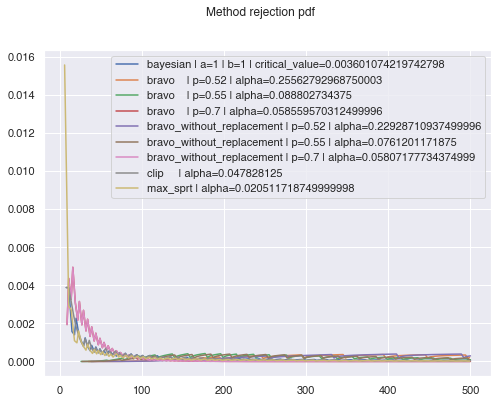

In [7]:
fig = plt.figure()
fig.suptitle("Method rejection pdf")

ax = fig.add_subplot(111)
data = pdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.set_ylim(0, 0.001)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

### cdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection cdf")

ax = fig.add_subplot(111)
data = cdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

# Plot cdf and pdf - 20000

In [ ]:
n = 20000
m = 2000
replacement=False
election = Election(n=n,m=m)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    if "bayesian_with_replacement" in str(method_dir):
        continue
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### pdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection pdf")

ax = fig.add_subplot(111)
data = pdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.set_ylim(0, 0.001)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

### cdf

StopIteration: 

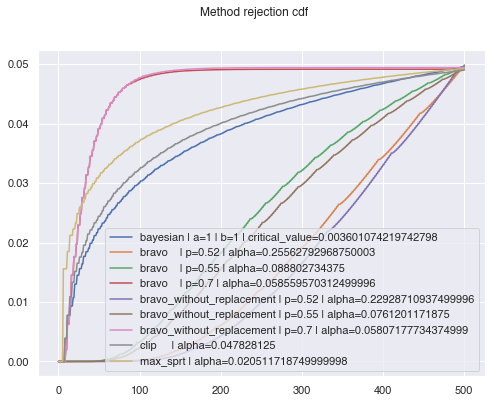

In [8]:
fig = plt.figure()
fig.suptitle("Method rejection cdf")

ax = fig.add_subplot(111)
data = cdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

# Compare with/without minstopping

In [ ]:
n = 5000
m = 500
replacement=False
election = Election(n=n,m=m)
election_data_dir = min_stop_calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    if "bayesian_with_replacement" in str(method_dir):
        continue
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### pdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection pdf")

ax = fig.add_subplot(111)
data = pdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.set_ylim(0, 0.001)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

### cdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection cdf")

ax = fig.add_subplot(111)
data = cdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

# count 10000

In [ ]:
from collections import defaultdict

n = 10000 
m = 1000
replacement=False
election = Election(n=n,m=m)
min_stop_data_dir = min_stop_calibrated_base_dir/str(election)

all_data = defaultdict(list)
for method_dir in min_stop_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df = {}
for datatype, li in all_data.items():
    all_data_df[datatype] = pd.concat([i.transpose() for i in li]).transpose()
    
    
normal_data_dir = calibrated_base_dir/str(election)
all_data = defaultdict(list)
for method_dir in normal_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df2 = {}
for datatype, li in all_data.items():
    all_data_df2[datatype] = pd.concat([i.transpose() for i in li]).transpose()

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

# count 5000

In [ ]:
from collections import defaultdict

n = 5000 
m = 500 
replacement=False
election = Election(n=n,m=m)
min_stop_data_dir = min_stop_calibrated_base_dir/str(election)

all_data = defaultdict(list)
for method_dir in min_stop_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df = {}
for datatype, li in all_data.items():
    all_data_df[datatype] = pd.concat([i.transpose() for i in li]).transpose()
    
    
normal_data_dir = calibrated_base_dir/str(election)
all_data = defaultdict(list)
for method_dir in normal_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df2 = {}
for datatype, li in all_data.items():
    all_data_df2[datatype] = pd.concat([i.transpose() for i in li]).transpose()

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bravo' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bayesian' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bayesian' in col or 'bravo' in col]], dashes=None)

## 20000

In [ ]:
n = 20000
m = 2000
replacement=False
election = Election(n=n,m=m)
election_data_dir = min_stop_calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    if "bayesian_with_replacement" in str(method_dir):
        continue
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### pdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection pdf")

ax = fig.add_subplot(111)
data = pdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.set_ylim(0, 0.001)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

### cdf

In [ ]:
fig = plt.figure()
fig.suptitle("Method rejection cdf")

ax = fig.add_subplot(111)
data = cdf_df[0.5]
styles_gen = map_styles_gen(data.index.get_level_values(0).unique())
for method, df in data.groupby(level=0):
    ls, cs, ms = next(styles_gen)
    df = df.droplevel(0)
    sns.lineplot(data=df, ax=ax, label=method, dashes=ls, palette=cs, markers=ms)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
legend=format_legend(ax, how=1)

# count power

In [ ]:
from collections import defaultdict

n = 5000 
m = 500 
replacement=False
election = Election(n=n,m=m)
min_stop_data_dir = min_stop_calibrated_base_dir/str(election)

all_data = defaultdict(list)
for method_dir in min_stop_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df = {}
for datatype, li in all_data.items():
    all_data_df[datatype] = pd.concat([i.transpose() for i in li]).transpose()
    
    
normal_data_dir = calibrated_base_dir/str(election)
all_data = defaultdict(list)
for method_dir in normal_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_")[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df2 = {}
for datatype, li in all_data.items():
    all_data_df2[datatype] = pd.concat([i.transpose() for i in li]).transpose()

In [ ]:
data = all_data_df["power"].join(
    all_data_df2["power"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bravo' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bayesian' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bayesian' in col or 'bravo' in col]], dashes=None)

# count power 20000

In [ ]:
from collections import defaultdict

n = 20000
m = 2000 
replacement=False
election = Election(n=n,m=m)
min_stop_data_dir = min_stop_calibrated_base_dir/str(election)

all_data = defaultdict(list)
for method_dir in min_stop_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_",1)[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df = {}
for datatype, li in all_data.items():
    all_data_df[datatype] = pd.concat([i.transpose() for i in li]).transpose()
    
    
normal_data_dir = calibrated_base_dir/str(election)
all_data = defaultdict(list)
for method_dir in normal_data_dir.iterdir():
    print(method_dir)
    for data_file in method_dir.iterdir():
        if 'cdf' not in str(data_file) and 'pdf' not in str(data_file):
            method = str(method_dir.name).rsplit("_",1)[0]
            datatype = str(data_file.name).split(".")[0].replace('{}_'.format(method), "")
            all_data[datatype].append(read_csv2(data_file))

all_data_df2 = {}
for datatype, li in all_data.items():
    all_data_df2[datatype] = pd.concat([i.transpose() for i in li]).transpose()

In [ ]:
data = all_data_df["power"].join(
    all_data_df2["power"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data, dashes=None)

In [ ]:
data = all_data_df["power"].join(
    all_data_df2["power"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if "bravo_without_replacement" in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns]], dashes=None)

In [ ]:
data = all_data_df["power"].join(
    all_data_df2["power"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if "truncated_bayesian" in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean"].join(
    all_data_df2["unconditional_mean"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'bravo_without_replacement' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if 'truncated_bayesian' in col]], dashes=None)

In [ ]:
data = all_data_df["unconditional_mean_with_recount"].join(
    all_data_df2["unconditional_mean_with_recount"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if col.startswith('bayesian') and 'bayesian |' in col 
                        or 'bravo_without_replacement' in col]], dashes=None)

In [ ]:
data = all_data_df["power"].join(
    all_data_df2["power"], 
    lsuffix=' | with min',
    rsuffix=' | no min')
fig = plt.figure(figsize=[20, 20])

sns.lineplot(data=data[[col for col in data.columns if col.startswith('bayesian') and 'bayesian |' in col 
                        or 'bravo_without_replacement' in col]], dashes=None)

# Report Plots

In [25]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

In [26]:
names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

## n = 5000

In [27]:
n = 5000
m = 500
replacement=False
election = Election(n=n,m=m)
# election_data_dir = min_stop_calibrated_base_dir/str(election)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdfs = pdfs[2], pdfs[4], pdfs[0], pdfs[6], pdfs[5], pdfs[3], pdfs[1]
cdfs = cdfs[2], cdfs[4], cdfs[0], cdfs[6], cdfs[5], cdfs[3], cdfs[1]
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### Pdf

In [28]:
pdf_df050 = pdf_df[[0.50]]
pdf_df050 = pdf_df050.reset_index()
pdf_df050.columns = ['method', 'sample_count', 'risk_pdf']
basenames = pdf_df050.method.apply(group_basename)
parameters = pdf_df050.method.apply(group_parameter)
basenames_with_type = pdf_df050.method.apply(group_basename_with_type)
parameters_with_type = pdf_df050.method.apply(group_parameter_with_type)
pdf_df050['basename'] = basenames
pdf_df050['basename_with_type'] = basenames_with_type
pdf_df050['parameter'] = parameters
pdf_df050['parameter_with_type'] = parameters_with_type
pdf_df050.head()

,method,sample_count,risk_pdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,9,0.001939,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,11,0.004364,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,14,0.003268,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,16,0.004948,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,19,0.003098,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


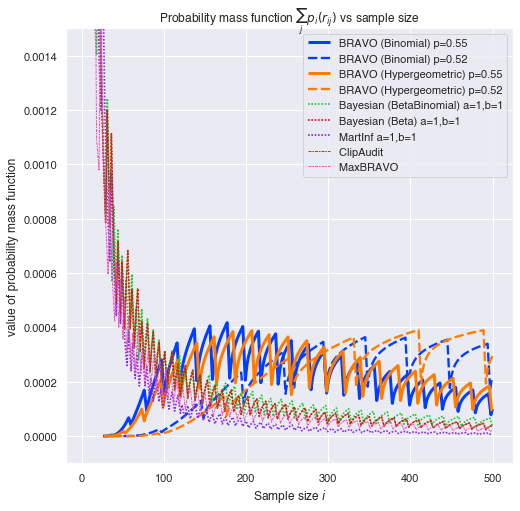

In [29]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = pdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_pdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             sizes=(1,3),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
plt.ylim(-0.0001, 0.0015)
plt.xlabel('Sample size $i$')
plt.ylabel('value of probability mass function')
plt.title('Probability mass function $\sum_jp_i(r_{ij})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/pmf_methods.png')

### CDF

In [30]:
cdf_df050 = cdf_df[[0.50]]
cdf_df050 = cdf_df050.reset_index()
cdf_df050.columns = ['method', 'sample_count', 'risk_cdf']
basenames = cdf_df050.method.apply(group_basename)
parameters = cdf_df050.method.apply(group_parameter)
basenames_with_type = cdf_df050.method.apply(group_basename_with_type)
parameters_with_type = cdf_df050.method.apply(group_parameter_with_type)
cdf_df050['basename'] = basenames
cdf_df050['basename_with_type'] = basenames_with_type
cdf_df050['parameter'] = parameters
cdf_df050['parameter_with_type'] = parameters_with_type
cdf_df050.head()

,method,sample_count,risk_cdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,0,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,1,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,2,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,3,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,4,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


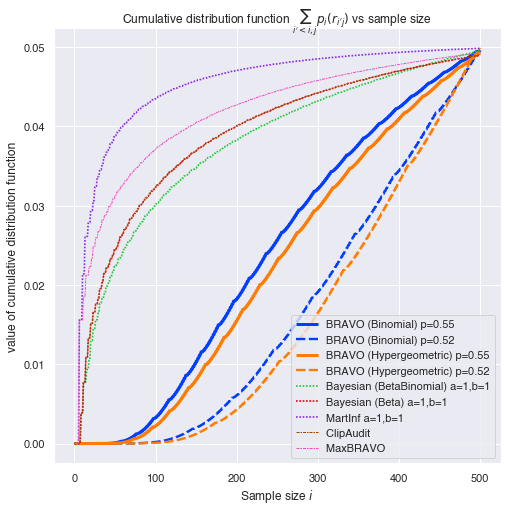

In [31]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = cdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_cdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             sizes=(1,3),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
# plt.ylim(-0.0001, None)
plt.xlabel('Sample size $i$')
plt.ylabel('value of cumulative distribution function')
plt.title('Cumulative distribution function $\sum_{i\'<i,j}p_i(r_{i\'j})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/cdf_methods.png')

## n = 500

In [32]:
n = 500
m = 500
replacement=False
election = Election(n=n,m=m)
# election_data_dir = min_stop_calibrated_base_dir/str(election)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))

pdfs = pdfs[2], pdfs[4], pdfs[0], pdfs[6], pdfs[5], pdfs[3], pdfs[1]
cdfs = cdfs[2], cdfs[4], cdfs[0], cdfs[6], cdfs[5], cdfs[3], cdfs[1]
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

In [33]:
names = [
    'type',
    'parameter'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_basename,
    group_parameter
]

### Pdf

In [34]:
pdf_df050 = pdf_df[[0.50]]
pdf_df050 = pdf_df050.reset_index()
pdf_df050.columns = ['method', 'sample_count', 'risk_pdf']
basenames = pdf_df050.method.apply(group_basename)
parameters = pdf_df050.method.apply(group_parameter)
basenames_with_type = pdf_df050.method.apply(group_basename_with_type)
parameters_with_type = pdf_df050.method.apply(group_parameter_with_type)
pdf_df050['basename'] = basenames
pdf_df050['basename_with_type'] = basenames_with_type
pdf_df050['parameter'] = parameters
pdf_df050['parameter_with_type'] = parameters_with_type
pdf_df050.head()

,method,sample_count,risk_pdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.06943880641460418,8,0.003690,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.06943880641460418,11,0.003637,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.06943880641460418,13,0.005919,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.06943880641460418,16,0.003749,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.06943880641460418,19,0.002597,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


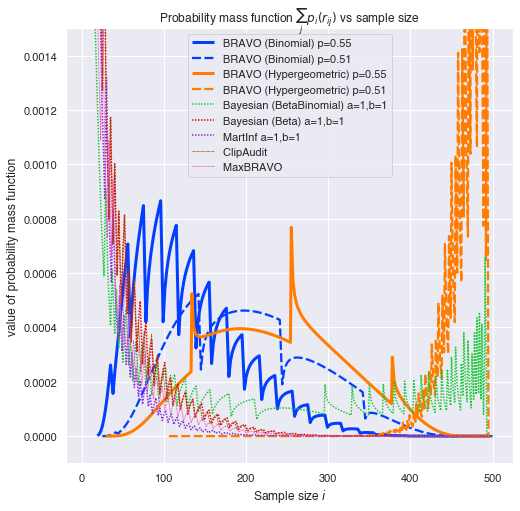

In [35]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = pdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_pdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
plt.ylim(-0.0001, 0.0015)
plt.xlabel('Sample size $i$')
plt.ylabel('value of probability mass function')
plt.title('Probability mass function $\sum_jp_i(r_{ij})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/pmf_methods_500.png')

### CDF

In [36]:
cdf_df050 = cdf_df[[0.50]]
cdf_df050 = cdf_df050.reset_index()
cdf_df050.columns = ['method', 'sample_count', 'risk_cdf']
basenames = cdf_df050.method.apply(group_basename)
parameters = cdf_df050.method.apply(group_parameter)
basenames_with_type = cdf_df050.method.apply(group_basename_with_type)
parameters_with_type = cdf_df050.method.apply(group_parameter_with_type)
cdf_df050['basename'] = basenames
cdf_df050['basename_with_type'] = basenames_with_type
cdf_df050['parameter'] = parameters
cdf_df050['parameter_with_type'] = parameters_with_type
cdf_df050.head()

,method,sample_count,risk_cdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.06943880641460418,0,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.06943880641460418,1,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.06943880641460418,2,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.06943880641460418,3,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.06943880641460418,4,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


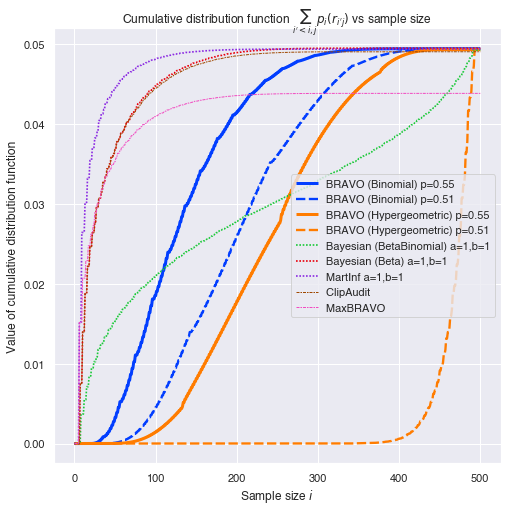

In [37]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = cdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_cdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             sizes=(1,3),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
# plt.ylim(-0.0001, None)
plt.xlabel('Sample size $i$')
plt.ylabel('Value of cumulative distribution function')
plt.title('Cumulative distribution function $\sum_{i\'<i,j}p_i(r_{i\'j})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/cdf_methods_500.png')

## n = 20000

In [38]:
n = 20000
m = 2000
replacement=False
election = Election(n=n,m=m)
# election_data_dir = min_stop_calibrated_base_dir/str(election)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdfs = pdfs[2], pdfs[4], pdfs[0], pdfs[6], pdfs[5], pdfs[3], pdfs[1]
cdfs = cdfs[2], cdfs[4], cdfs[0], cdfs[6], cdfs[5], cdfs[3], cdfs[1]
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

In [39]:
names = [
    'type',
    'parameter'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_basename,
    group_parameter
]

### Pdf

In [40]:
pdf_df050 = pdf_df[[0.50]]
pdf_df050 = pdf_df050.reset_index()
pdf_df050.columns = ['method', 'sample_count', 'risk_pdf']
basenames = pdf_df050.method.apply(group_basename)
parameters = pdf_df050.method.apply(group_parameter)
basenames_with_type = pdf_df050.method.apply(group_basename_with_type)
parameters_with_type = pdf_df050.method.apply(group_parameter_with_type)
pdf_df050['basename'] = basenames
pdf_df050['basename_with_type'] = basenames_with_type
pdf_df050['parameter'] = parameters
pdf_df050['parameter_with_type'] = parameters_with_type
pdf_df050.head()

,method,sample_count,risk_pdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,9,0.001950,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,11,0.004387,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,14,0.003289,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,16,0.004979,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,19,0.003122,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


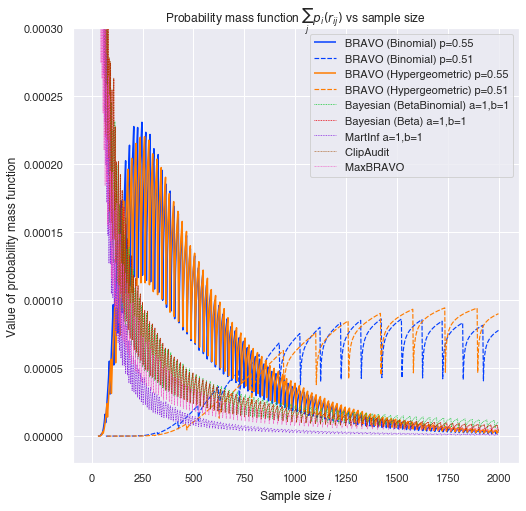

In [41]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = pdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_pdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             sizes=(0.5,1.5),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
plt.ylim(-0.00002, 0.0003)
plt.xlabel('Sample size $i$')
plt.ylabel('Value of probability mass function')
plt.title('Probability mass function $\sum_jp_i(r_{ij})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/pmf_methods_20000.png')

### CDF

In [42]:
cdf_df050 = cdf_df[[0.50]]
cdf_df050 = cdf_df050.reset_index()
cdf_df050.columns = ['method', 'sample_count', 'risk_cdf']
basenames = cdf_df050.method.apply(group_basename)
parameters = cdf_df050.method.apply(group_parameter)
basenames_with_type = cdf_df050.method.apply(group_basename_with_type)
parameters_with_type = cdf_df050.method.apply(group_parameter_with_type)
cdf_df050['basename'] = basenames
cdf_df050['basename_with_type'] = basenames_with_type
cdf_df050['parameter'] = parameters
cdf_df050['parameter_with_type'] = parameters_with_type
cdf_df050.head()

,method,sample_count,risk_cdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,0,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,1,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,2,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,3,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,4,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


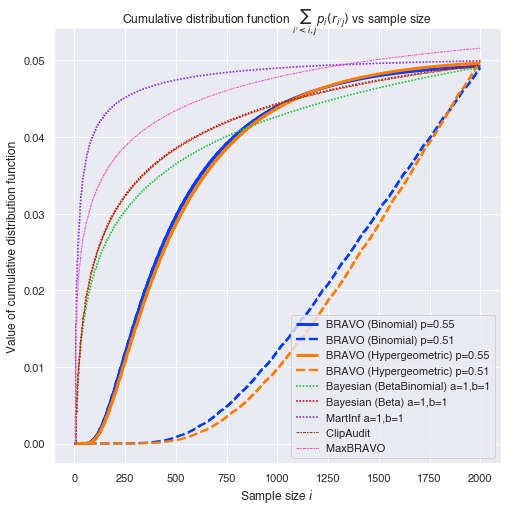

In [43]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = cdf_df050.query('parameter != "p=0.7"')
sns.lineplot(x='sample_count', 
             y='risk_cdf', 
             hue='basename_with_type', 
             size='parameter', 
             style='parameter', 
             palette='bright',
             sizes=(1,3),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
# plt.ylim(-0.0001, None)
plt.xlabel('Sample size $i$')
plt.ylabel('Value of cumulative distribution function')
plt.title('Cumulative distribution function $\sum_{i\'<i,j}p_i(r_{i\'j})$ vs sample size')
ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/cdf_methods_20000.png')